In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sctats

# **CPS 6:** Profit and Loss of the Black-Scholes hedging

## **1**

We want to simulate the Ornstein-Uhlenbeck process
$$
    d\sigma_t = \lambda(c-\sigma_t)\,dt + \gamma\, dW_t^{(2)}
$$
which has solution
$$
    \sigma_t = c + (\sigma_0-c)e^{-\lambda t} + \gamma\int_0^t e^{-\lambda(t-s)}\,dW_s^{(2)}.
$$

First we define a set of parameters for plotting and testing:

In [7]:
tmax = 1
n = 100
S0 = 100
sig0 = 0.4
lbda = 2.0
c = 0.4
gamma = 0.3

In [3]:
def sigma_t(sig0, c, lbda, gamma, tmax, n, N=1000):
    """Ornstein-Uhlenbeck process.
    
    Args:
        N: number of copies (default=1000)
    
    Shape:
        N * n
    """
    dt = tmax/n
    dwt = np.zeros((n, N))
    dwt[1:] = np.sqrt(dt)*np.random.randn(n-1, N)
    times = np.linspace(0, tmax, n, endpoint=True)[:,None]
    integral_term = np.cumsum(np.exp(lbda*times)*dwt, axis=0)
    integral_term = np.exp(-lbda*times)*integral_term
    res = c + (sig0-c)*np.exp(-lbda*times) + gamma*integral_term
    return np.transpose(res)

We plot a single, example trajectory of the Ornstein-Uhlenbeck process (with a modified start value $\sigma_0 = 1.0$ to check the dynamics).

Text(0.5, 1.0, 'Volatility process $\\sigma_t$')

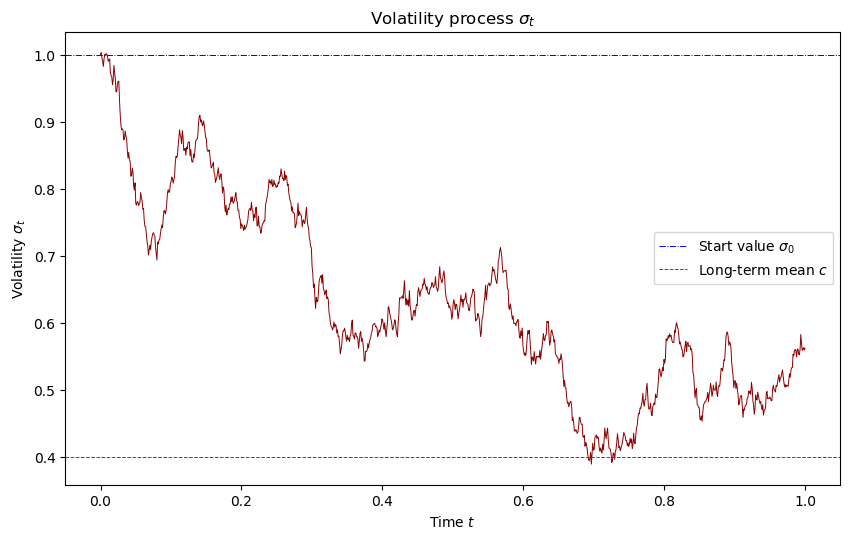

In [4]:
n = 1000
sig0 = 1.0 # different from c to check the dynamics
times = np.linspace(0, tmax, n, endpoint=True)
sig_trajectory = sigma_t(sig0, c, lbda, gamma, tmax, n, N=1)
plt.figure(figsize=(10,6), dpi=100)
plt.plot(times, sig_trajectory[0], linewidth=.7, c='darkred')
plt.xlabel('Time $t$')
plt.ylabel('Volatility $\sigma_t$')
plt.axhline(sig0, times.min(), times.max(), c='blue', linewidth=.7, linestyle='-.', label="Start value $\sigma_0$")
plt.axhline(c, times.min(), times.max(), c='green', linewidth=.7, linestyle='--', label="Long-term mean $c$")
plt.legend()
plt.title('Volatility process $\sigma_t$')

The dynamics are coherent, the Ornstein-Uhlenbeck volatility $\sigma_t$ has a tendency to decrease to $c = 0.4$.

## **2**

In [35]:
def asset_price(S0, sig0, lbda, c, gamma, tmax, n, N=1000, sigma_traj=None):
    """Asset price process.
    
    Args:
        N: number of copies (default=1000)
        sigma_traj: volatility process (optional, generated by the function call), shape N * n
    
    Shape:
        N * n
    """
    # Realisation of sigma on [0, tmax]
    # if not supplied
    if sigma_traj is None:
        # print("Generating volatility process.")
        # Shape n * N
        sigma_traj = sigma_t(sig0, c, lbda, gamma, tmax, n-1, N=N).transpose()
    else:
        # print("Using provided volatility process.")
        N = sigma_traj.shape[0]
        sigma_traj = sigma_traj[:,:-1].transpose()
    dt = tmax/n
    times = np.linspace(0, tmax, n, endpoint=True)
    # Volatility term: integral w.r.t. time (computed at discrete times < t)
    vol_integral = np.zeros((n, N))
    vol_integral[1:] = np.cumsum(np.power(sigma_traj, 2)*dt, axis=0)
    # Sample trajectories of second brownian process
    dwt = np.sqrt(dt)*np.random.randn(n-1, N)
    # Drift term: stochastic integral w.r.t. second brownian process
    drift_integral = np.zeros((n, N))
    drift_integral[1:] = np.cumsum(sigma_traj*dwt, axis=0)
    return S0*np.exp(-0.5*vol_integral + drift_integral).transpose()

Using provided volatility process.


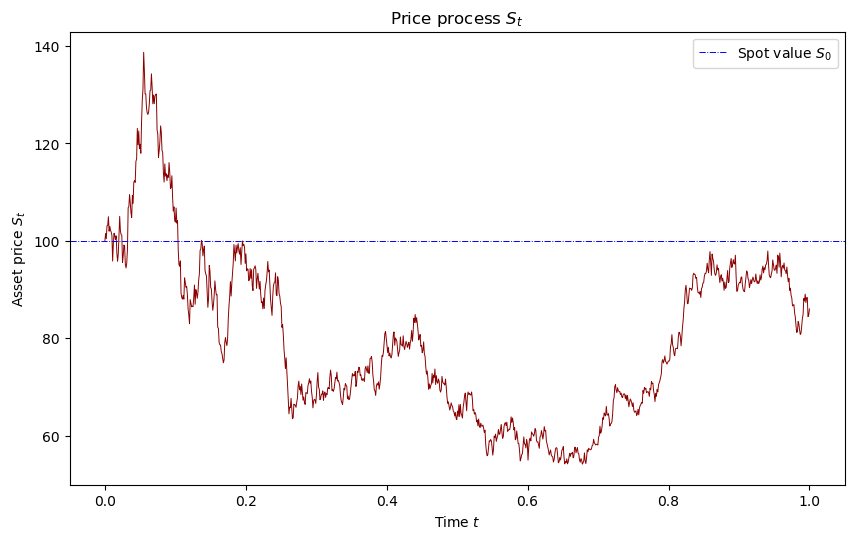

In [8]:
n = 1000
times = np.linspace(0, tmax, n, endpoint=True)
asset_trajectory = asset_price(S0, sig0, c, lbda, gamma, tmax, n, sigma_traj=sig_trajectory)
plt.figure(figsize=(10,6), dpi=100)
plt.plot(times, asset_trajectory[0], linewidth=.7, c='darkred') # plot the first such trajectory
plt.xlabel('Time $t$')
plt.ylabel('Asset price $S_t$')
plt.title('Price process $S_t$')
plt.axhline(S0, times.min(), times.max(), c='blue', linewidth=.7, linestyle='-.', label="Spot value $S_0$")
plt.legend()

## **3**

On doit introduire la grecque
$$
    \Gamma(t, s, \Sigma) := \partial^2_{ss}C^{BS}(t, s, \Sigma) = .
$$

Puis le P&L
$$
    P\&L(\Sigma) = \frac12\int_0^T e^{r(T-u)} (\Sigma^2 - \sigma_u^2)S_u^2\Gamma^{BS}(u, S_u, \Sigma) \, du
$$

In [126]:
def BS_gamma(t, S0, sigm, K, r, tmax):
    """
    Greek gamma; second derivative of the Black-Scholes call price.
    
    Args:
        t: time to maturity (maturity - current time)
        S0: spot price
        sigm: volatility
        K: strike
        r: interest rate
        tmax: maturity
    """
    Kr = K*np.exp(-r*tmax) # discounted strike
    s2T = sigm**2*tmax
    dp = np.log(S0/Kr)/np.sqrt(s2T) + 0.5*np.sqrt(s2T)
    return sctats.norm.pdf(dp)/(S0*sigm*np.sqrt(tmax - t))

In [116]:
def prof_and_loss(sigm, r, K, S0, sig0, c, lbda, gamma, tmax, n, N):
    """
    Compute the profit and loss.
    
    Args:
        sigm: volatility
        r: interest rate
        K: option strike array
        S0: spot price
    """
    dt = tmax/n
    # Compute volatility trajectories
    sigma_traj = sigma_t(sig0, c, lbda, gamma, tmax, n, N)
    # Compute asset price, shape N * n
    asset_traj = asset_price(S0, sig0, lbda, c, gamma, tmax, n, sigma_traj=sigma_traj)
    # Shape (n-1) * N
    asset_traj = asset_traj.T[:-1]
    sigma_traj = sigma_traj.T[:-1]
    times = np.linspace(0, tmax, n)[:-1]
    # Shape (n-1) * N
    greek_gamma = BS_gamma(times[:,None], asset_traj, sigm, K, r, tmax)
    # Make the integrand, shape N * n
    integrand = np.exp(r*(tmax - times[:,None]))*(sigm**2 - sigma_traj**2)*(asset_traj**2)*greek_gamma
    integral_ =  np.sum(integrand*dt, axis=0)
    return 0.5*integral_

In [117]:
S0 = 100
tmax = 1
sig0 = 0.4
lbda = 2.0
c = 0.4
gamma = 0.3
sigm = sig0
r = 0.02
print("sigma0 = %.3f" % sig0)
print("lambda = %.3f" % lbda)
print("Σ = %.3f" % sigm)
print("r = %.3f" % r)
n = 100
N = 1000
print("No. of copies: %d" % N)

sigma0 = 0.400
lambda = 2.000
Σ = 0.400
r = 0.020
No. of copies: 1000


In [118]:
n_range = range(50,101,10)
K_range = np.array(range(105,251,1))
print(len(n_range))
print(len(K_range))

6
146


In [119]:
samples_matrix = np.empty((6, len(K_range), N))
for i,n in enumerate(n_range):
    print('n = %d' % n)
    # print('Strike\t\tMean\t\tVariance')
    for j, strike in enumerate(K_range):
        pnl_sample = prof_and_loss(sigm, r, strike, S0, sig0, c, lbda, gamma, tmax, n, N)
        samples_matrix[i, j, :] = pnl_sample

n = 50
n = 60
n = 70
n = 80
n = 90
n = 100


In [120]:
samples_matrix.shape

(6, 146, 1000)

In [121]:
means_matrix = samples_matrix.mean(axis=2)
varia_matrix = samples_matrix.var(axis=2)

In [123]:
means_matrix.shape

(6, 146)

First dimension: $n$ values
Second dimension: values of $K$

Text(0.5, 0, 'Strike $K$')

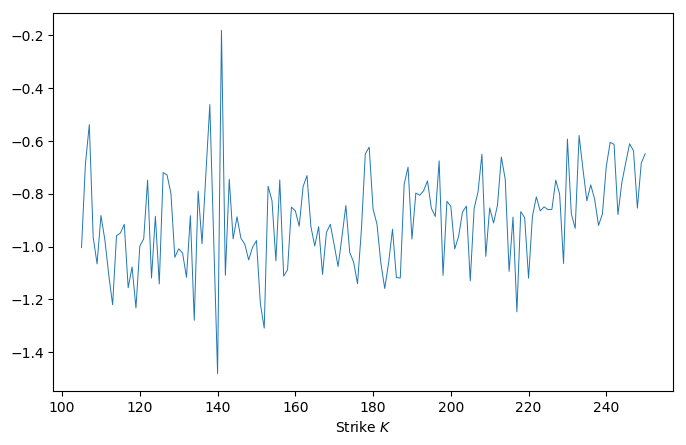

In [125]:
plt.figure(figsize=(8,5), dpi=100)
plt.plot(K_range, means_matrix[-1,:], linewidth=.7)
# plt.plot(K_range, np.sqrt(varia_matrix)[-1,:], linewidth=.7)
plt.xlabel('Strike $K$')